# Load data

"spider\train_spider.json"

In [2]:
import pandas as pd
import warnings


warnings.filterwarnings('ignore')

class Train_Data():
    
    '''
    Train_Data class Loads the data from multiple Training JSON files in Pandas Dataframes
    '''
   
    def __init__(self, path , filenames):
        '''
            Parameters
            ------------
            path: directory where English to SQL translation JSON are placed
            filenames: Json file names containing Train data
        '''
        self.path = path
        self.filenames = filenames
        self.df_train = pd.DataFrame()
        for f in self.filenames:
            print("Reading file at path", self.path+f)
            try:
                df = pd.read_json(self.path + f)
                if len(self.df_train) == 0:
                    self.df_train = df
                else:
                    self.df_train = self.df_train.append(df)
                print("{} Rows in Total".format(len(self.df_train)))
            except Exception as e:
                print("Got error while Reading file : " , e)
                
    @property          
    def questions(self):
        ''' 
        Returns
        ------------
        Returns English Questions in Dataframe Rows as List
        '''
        return self.df_train.question.values.tolist()
    
    @property
    def sql(self):
        '''
        Returns
        ------------
        Returns SQL in Dataframe Rows as List
        '''
        return self.df_train['query'].values.tolist()
    
    @property          
    def question_tokens(self):
        ''' 
        Returns
        ------------
        Returns English Question Tokens in Dataframe Rows as List
        '''
        
        return self.df_train['question_toks'].values.tolist()
    
    @property
    def sql_tokens(self):
        ''' 
        Returns
        ------------
        Returns SQL Query Tokens in Dataframe Rows as List
        '''
        return self.df_train['query_toks'].values.tolist()
    
    def get_special_characters(self,list_of_text):
        '''
        Parameters
        ------------
        list_of_text: Input List of Text 
        Returns
        ------------
        Provides list of Special Characters in the text
        '''
        return list(set(Preprocess.special_char(''.join([''.join(ele) for ele in list_of_text]))))
    
    def get_vocab_size(self, list_of_text):
        """
        Parameters
        ------------
        list_of_text: Input List of Text 
        
        Returns
        ------------
        Vocabulary size or unique words in the corpus
        """
        word_list = []
        for sentence in list_of_text:
            for word in sentence.split():
                word = word.lower().strip()
                if word not in word_list:
                    word_list.append(word)
        return len(word_list), word_list
        
    
    
    
    
    
    
#################################
#CONSTANTS

EOS = '[END]'
SOS = '[START]'  
    
    
    
    
    
#################################################################################################################
    
import re
import tensorflow as tf
import tensorflow_text as tf_text

class Preprocess():
    def __init__(self,text):
        """
            Parameters
            ------------
            text : Input string
            Runs the text processing steps
            
        """
        self.processed_text = self.run_pipeline(text)
    
    def text_standardize(self, text):
        """
            Parameters
            ------------
            text : Input string
            
            Returns
            ------------
            -   Unicode normalization using NFKD method
            -   Lower Case text
        
        """
        text = tf_text.normalize_utf8(text, 'NFKD')
        text = tf.strings.lower(text)
        return text
    
    def text_whitespace(self, text):
        """
            Parameters
            ------------
            text : Input string
            
            Returns
            ------------
            -   Remove $ and \\ special characters 
            -   Add space around punctations
            -   Remove spaces around sentences
        
        """
        text = tf.strings.regex_replace(text, '[$\\\\]', '')
        text = tf.strings.regex_replace(text, '[.?!,¿()*:@]', r' \0 ')
        text = tf.strings.strip(text)
        return text
    
    def add_SOS_EOS(self, text):
        """
            Parameters
            ------------
            text : Input string
            
            Returns
            ------------
            -   Add <SOS> and <EOS> tags to each sentence
        
        """
        text = tf.strings.join([SOS, text, EOS], separator=' ')
        return text
    
    @classmethod
    def special_char(cls, text):
        """
            Parameters
            ------------
            text : Input string
            
            Returns
            ------------
            -   Special Characters found in Text using Regular Expression
        """
        return re.findall(r'[\W]',text.replace(' ',''))
    
    
    def run_pipeline(self,text):
        """
            Parameters
            ------------
            text : Input string
            
            Returns
            ------------
            Executes series of Text pre processing functions
        
        """
        text = self.text_standardize(text)
        text = self.text_whitespace(text)
        text = self.add_SOS_EOS(text)
        self.text = text
        return self.text
        

In [6]:
try:
    del(o)
except:
    pass
o = Train_Data('D:/DS/Learnin/Essex MS/CE888/git/CE888/assignment2/seq2seq/spider/',['train_spider.json','train_others.json'])

Reading file at path D:/DS/Learnin/Essex MS/CE888/git/CE888/assignment2/seq2seq/spider/train_spider.json
7000 Rows in Total
Reading file at path D:/DS/Learnin/Essex MS/CE888/git/CE888/assignment2/seq2seq/spider/train_others.json
8659 Rows in Total


In [8]:
Preprocess(o.sql[0]).processed_text.numpy().decode()

'[START] select count (  *  )  from head where age  >  56 [END]'

In [9]:
# o.get_special_characters(o.sql)
# o.get_special_characters(o.questions)
# o.get_vocab_size(o.questions)
_,w = o.get_vocab_size(o.questions)

In [10]:
# ''.join([''.join(ele) for ele in o.questions])

In [11]:
def tf_lower_and_split_punct(text):
    return Preprocess(text).processed_text

In [12]:
max_vocab_size = 7000

input_text_processor = tf.keras.layers.TextVectorization( standardize=tf_lower_and_split_punct, max_tokens=max_vocab_size)
input_text_processor.adapt(o.questions)
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', 'the', '[START]', '[END]', 'of', '?', '.', 'what', 'are']

In [13]:
output_text_processor = tf.keras.layers.TextVectorization(    standardize=tf_lower_and_split_punct,    max_tokens=max_vocab_size)

output_text_processor.adapt(o.sql)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '.', 't1', 't2', '=', 'select', 'from', 'as', '[START]']

In [14]:
input_text_processor.vocabulary_size()

3955

In [15]:
inp = o.questions
targ = o.sql

In [16]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

In [17]:
dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [18]:
for example_input_batch, example_target_batch in dataset.take(1):
    print(example_input_batch[:5])
    print()
    print(example_target_batch[:5])
    break

tf.Tensor(
[b'How many addresses are there in country USA?'
 b'Count the number of wrestlers.'
 b'Show all cities along with the number of drama workshop groups in each city.'
 b'List the names of hosts who did not serve as a host of any party in our record.'
 b'what papers were published in Academic radiology in 1995 ?'], shape=(5,), dtype=string)

tf.Tensor(
[b"SELECT count(*) FROM addresses WHERE country  =  'USA'"
 b'SELECT count(*) FROM wrestler'
 b'SELECT T1.City_Town ,  count(*) FROM Addresses AS T1 JOIN Drama_Workshop_Groups AS T2 ON T1.Address_ID  =  T2.Address_ID GROUP BY T1.City_Town'
 b'SELECT Name FROM HOST WHERE Host_ID NOT IN (SELECT Host_ID FROM party_host)'
 b'SELECT DISTINCT t2.paperid FROM paper AS t2 JOIN journal AS t1 ON t2.journalid  =  t1.journalid WHERE t1.journalname  =  "Academic radiology" AND t2.year  =  1995;'], shape=(5,), dtype=string)


In [19]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :]

<tf.Tensor: shape=(3, 27), dtype=int64, numpy=
array([[  3,  22,  25, 272,   9,  58,  11, 115, 262,   6,   4,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [  3,  59,   2,  18,   5, 371,   7,   4,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [  3,  26,  15,  71, 492,  16,   2,  18,   5, 805, 451, 613,  11,
         31,  65,   7,   4,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0]], dtype=int64)>

In [20]:
import numpy as np
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] how many addresses are there in country usa ? [END]                '

Text(0.5, 1.0, 'Mask')

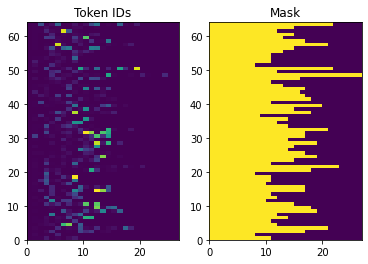

In [21]:
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [22]:
embedding_dim = 256
units = 1024

In [23]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                                embedding_dim)

        # The GRU RNN layer processes those vectors sequentially.
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                    # Return the sequence and state
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')

    def call(self, tokens, state=None):
        


        # 2. The embedding layer looks up the embedding for each token.
        vectors = self.embedding(tokens)


        # 3. The GRU processes the embedding sequence.
        #    output shape: (batch, s, enc_units)
        #    state shape: (batch, enc_units)
        output, state = self.gru(vectors, initial_state=state)


        # 4. Returns the new sequence and its state.
        return output, state

In [24]:
input_text_processor.vocabulary_size()

3955

In [25]:
# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 27)
Encoder output, shape (batch, s, units): (64, 27, 1024)
Encoder state, shape (batch, units): (64, 1024)


In [26]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        # For Eqn. (4), the  Bahdanau attention
        self.W1 = tf.keras.layers.Dense(units, use_bias=False)
        self.W2 = tf.keras.layers.Dense(units, use_bias=False)

        self.attention = tf.keras.layers.AdditiveAttention()

    def call(self, query, value, mask):
       
        # From Eqn. (4), `W1@ht`.
        w1_query = self.W1(query)
       
        # From Eqn. (4), `W2@hs`.
        w2_key = self.W2(value)

        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask

        context_vector, attention_weights = self.attention(
            inputs = [w1_query, value, w2_key],
            mask=[query_mask, value_mask],
            return_attention_scores = True,
        )

        return context_vector, attention_weights

In [27]:
attention_layer = BahdanauAttention(units)

In [28]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens

context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 27)


Text(0.5, 1.0, 'Mask')

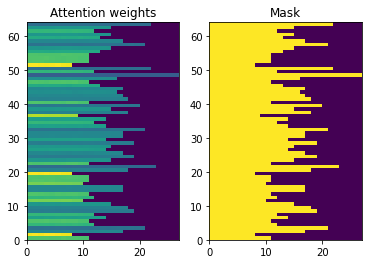

In [29]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [30]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

In [31]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [32]:
import typing
from typing import Any, Tuple

class DecoderInput(typing.NamedTuple):
    new_tokens: Any
    enc_output: Any
    mask: Any

class DecoderOutput(typing.NamedTuple):
    logits: Any
    attention_weights: Any

In [33]:
def call(self, inputs: DecoderInput, state=None) -> Tuple[DecoderOutput, tf.Tensor]:

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)
 

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)

  return DecoderOutput(logits, attention_weights), state

In [34]:
Decoder.call = call

In [35]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

In [36]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [37]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 3821)
state shape: (batch_size, dec_units) (64, 1024)


In [38]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

In [39]:
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['"2008"'],
       ['brand'],
       ['"violence"'],
       ["'c"],
       ['"right']], dtype='<U38')

In [40]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)

In [41]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['"progress'],
       ['"chinese'],
       ['features"'],
       ['uk_vat_number'],
       ['company']], dtype='<U38')

In [42]:
class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self):
        self.name = 'masked_loss'
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction='none')

    def __call__(self, y_true, y_pred):
        # Calculate the loss for each item in the batch.
        loss = self.loss(y_true, y_pred)

        # Mask off the losses on padding.
        mask = tf.cast(y_true != 0, tf.float32)
        loss *= mask

        # Return the total.
        return tf.reduce_sum(loss)

In [43]:
class TrainTranslator(tf.keras.Model):
    def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
        super().__init__()
        # Build the encoder and decoder
        encoder = Encoder(input_text_processor.vocabulary_size(),
                        embedding_dim, units)
        decoder = Decoder(output_text_processor.vocabulary_size(),
                        embedding_dim, units)

        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        self.use_tf_function = use_tf_function

    def train_step(self, inputs):
        if self.use_tf_function:
            return self._tf_train_step(inputs)
        else:
         return self._train_step(inputs)

In [44]:
def _preprocess(self, input_text, target_text):
  

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  

  # Convert IDs to masks.
  input_mask = input_tokens != 0
 

  target_mask = target_tokens != 0
  

  return input_tokens, input_mask, target_tokens, target_mask

In [45]:
TrainTranslator._preprocess = _preprocess

In [46]:
def _train_step(self, inputs):
    input_text, target_text = inputs  

    (input_tokens, input_mask,target_tokens, target_mask) = self._preprocess(input_text, target_text)

    max_target_length = tf.shape(target_tokens)[1]

    with tf.GradientTape() as tape:
        # Encode the input
        enc_output, enc_state = self.encoder(input_tokens)
        

        # Initialize the decoder's state to the encoder's final state.
        # This only works if the encoder and decoder have the same number of
        # units.
        dec_state = enc_state
        loss = tf.constant(0.0)

        for t in tf.range(max_target_length-1):
            # Pass in two tokens from the target sequence:
            # 1. The current input to the decoder.
            # 2. The target for the decoder's next prediction.
            new_tokens = target_tokens[:, t:t+2]
            step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                                    enc_output, dec_state)
            loss = loss + step_loss

    # Average the loss over all non padding tokens.
        average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

    # Apply an optimization step
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}

In [47]:
TrainTranslator._train_step = _train_step

In [48]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
    input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

    # Run the decoder one step.
    decoder_input = DecoderInput(new_tokens=input_token,
                                enc_output=enc_output,
                                mask=input_mask)

    dec_result, dec_state = self.decoder(decoder_input, state=dec_state)


    # `self.loss` returns the total for non-padded tokens
    y = target_token
    y_pred = dec_result.logits
    step_loss = self.loss(y, y_pred)

    return step_loss, dec_state

In [49]:
TrainTranslator._loop_step = _loop_step

In [50]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [51]:
np.log(output_text_processor.vocabulary_size())

8.2482674474469

In [52]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.9544973>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.9185286>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.845946>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.6102967>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.3306227>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.1428227>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=8.914141>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.659821>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.508311>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.4717817>}

Wall time: 2min 48s


In [53]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

In [54]:
TrainTranslator._tf_train_step = _tf_train_step


In [55]:
translator.use_tf_function = True


In [56]:
translator.train_step([example_input_batch, example_target_batch])


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.415348>}

In [57]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.347183>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.292658>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2191463>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.134287>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.074154>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0340776>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.012595>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.016451>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.031611>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.028635>}

Wall time: 1min 40s


....................................................................................................


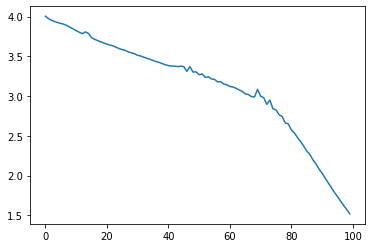

In [58]:
losses = []
for n in range(100):
  print('.', end='')
  logs = translator.train_step([example_input_batch, example_target_batch])
  losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

In [61]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [62]:
class BatchLogs(tf.keras.callbacks.Callback):
    def __init__(self, key):
        self.key = key
        self.logs = []

    def on_train_batch_end(self, n, logs):
        self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [64]:
train_translator.fit(dataset, epochs=3, callbacks=[batch_loss])

Epoch 1/3
136/136 [==============================] - 1013s 7s/step - batch_loss: 4.1028
Epoch 2/3
136/136 [==============================] - 1035s 8s/step - batch_loss: 1.8521
Epoch 3/3
136/136 [==============================] - 1035s 8s/step - batch_loss: 1.4737


Text(0, 0.5, 'CE/token')

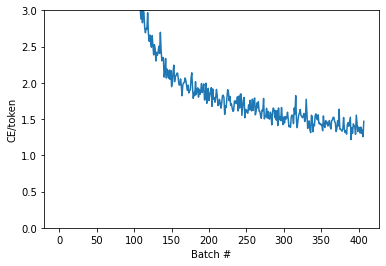

In [65]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

In [66]:
class Translator(tf.Module):
    
  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

In [67]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

In [68]:
def tokens_to_text(self, result_tokens):
    
    result_text_tokens = self.output_token_string_from_index(result_tokens)
   

    result_text = tf.strings.reduce_join(result_text_tokens,
                                        axis=1, separator=' ')
    

    result_text = tf.strings.strip(result_text)
    
    return result_text

In [69]:
Translator.tokens_to_text = tokens_to_text

In [70]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()

array([b'"department domestic_passengers', b'in role_code',
       b'mako "alabama"', b'manufacturer on_call', b'physician "duke"'],
      dtype=object)

In [71]:
def sample(self, logits, temperature):

    token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]

    # Set the logits for all masked tokens to -inf, so they are never chosen.
    logits = tf.where(self.token_mask, -np.inf, logits)

    if temperature == 0.0:
        new_tokens = tf.argmax(logits, axis=-1)
    else: 
        logits = tf.squeeze(logits, axis=1)
        new_tokens = tf.random.categorical(logits/temperature,
                                            num_samples=1)

    return new_tokens

Translator.sample = sample


In [72]:
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[ 297],
       [2298],
       [1002],
       [1741],
       [3666]], dtype=int64)>

In [73]:
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}

In [74]:
Translator.translate = translate_unrolled

In [76]:
%%time
input_text = tf.constant([
    'How many singers do we have?', # "It's really cold here."
    'What is the total number of singers?', # "This is my life.""
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

select t1 . name from authors as t1 join band as t2 on t1 . characteristic_id = t2 . stuid where t1 . country = "il";
select t1 . title from cast as t4 join actor as t2 on t1 . aid = t1 . jid join mid as t3 on t3 . mid = t1 . msid where t3 . title = 'acct-211'

Wall time: 634 ms
